# Sentiment Index FinBERT

In [ ]:
# %pip install transformers

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from transformers import pipeline

from data.finnhub_api import FinnhubClient  # your simple client


## Fetch news per ticker

In [ ]:
# FINNHUB_API_KEY = os.environ.get("FINNHUB_API_KEY", "YOUR_KEY_HERE")
FINNHUB_API_KEY = "d5lbg61r01qgquflgn9gd5lbg61r01qgquflgna0"

TICKER = "AAPL"
START_DATE = "2025-12-15"   # keep recent for prototype
END_DATE   = "2026-01-16"   # inclusive end for Finnhub call

client = FinnhubClient(api_key=FINNHUB_API_KEY)
news = client.company_news(TICKER, START_DATE, END_DATE)

print("n_articles:", len(news))
news[:2]


## Convert to DataFrame + extract date

In [ ]:
df_news = pd.DataFrame(news)

# Finnhub returns unix epoch seconds in "datetime"
df_news["published_dt"] = pd.to_datetime(df_news["datetime"], unit="s", utc=True)
df_news["date"] = df_news["published_dt"].dt.date

df_news = df_news.sort_values("published_dt").reset_index(drop=True)
df_news[["published_dt", "date", "headline", "source"]].head()


## Load FinBERT and score headlines

In [ ]:
sent_pipe = pipeline(
    "text-classification",
    model="ProsusAI/finbert",
    return_all_scores=True,
    truncation=True
)

def finbert_score(headlines, batch_size=16):
    """
    Returns sentiment score per headline: pos_prob - neg_prob
    """
    outputs = sent_pipe(list(headlines), batch_size=batch_size)
    scores = []
    for out in outputs:
        d = {x["label"].lower(): float(x["score"]) for x in out}
        pos = d.get("positive", 0.0)
        neg = d.get("negative", 0.0)
        scores.append(pos - neg)
    return np.array(scores, dtype=np.float32)

# Score
df_news["sent"] = finbert_score(df_news["headline"].fillna("").astype(str).tolist(), batch_size=16)
df_news[["date", "headline", "sent"]].head(10)


## Aggregate daily sentiment

In [ ]:
daily = (
    df_news.groupby("date")
    .agg(sentiment=("sent", "mean"), n_articles=("sent", "size"))
    .reset_index()
)

daily.head()


## Fetch daily price and merge

In [ ]:
# yfinance end is exclusive; add one day to include END_DATE in the download window
prices = yf.download(
    TICKER,
    start=START_DATE,
    end=pd.to_datetime(END_DATE) + pd.Timedelta(days=1),
    interval="1d",
    auto_adjust=False
)

# Reset index
df_price = prices.reset_index()

# Flatten MultiIndex columns if present
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(0)

# Create date column
df_price["date"] = pd.to_datetime(df_price["Date"]).dt.date

# Keep only what we need
df_price = df_price[["date", "Close"]].rename(columns={"Close": "close"})

print(df_price.head())


merged = pd.merge(df_price, daily, on="date", how="left")

merged.head(10)


## Plot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

start_sent = daily["date"].min()
end_sent = daily["date"].max()

print(merged.tail(10))

merged_focus = merged[(merged["date"] >= start_sent) & (merged["date"] <= end_sent)].copy()
merged_focus

# m = merged_focus.copy()
# m["date_dt"] = pd.to_datetime(m["date"])

# fig, ax1 = plt.subplots(figsize=(12, 5))
# ax1.plot(m["date_dt"], m["close"])
# ax1.set_ylabel("Close")

# ax2 = ax1.twinx()
# ax2.plot(m["date_dt"], m["sentiment"])
# ax2.set_ylabel("Daily Sentiment")

# plt.title(f"{TICKER}: Close vs Daily News Sentiment")
# plt.show()


(7450, 12)
[[ 4.08109741e+01  4.08276024e+01  3.15816669e+01 -2.70877719e-01
  -4.79453877e-02  2.97731256e+00 -5.23300469e-02 -5.85836800e+08
   3.62200584e+01 -1.53818008e+02  0.00000000e+00  0.00000000e+00]
 [ 4.05376701e+01  4.07710419e+01  3.31865501e+01 -2.84501195e-01
   4.68330123e-02  2.99578834e+00 -6.51588291e-02 -4.55921216e+08
   4.20403099e+01 -1.51019608e+02  0.00000000e+00  0.00000000e+00]
 [ 4.02688179e+01  4.07189369e+01  3.10222797e+01 -2.73089349e-01
   1.11677885e-01  2.98786283e+00 -6.40410557e-02 -2.66998000e+08
   4.50310478e+01 -1.48890610e+02  0.00000000e+00  0.00000000e+00]]
features shape: (7450, 12)
prices shape: (7450,)
features finite: True
prices finite: True
state_dim: 12
cfg.agent.state_dim: 0
sentiment stats:
  min: -0.790291
  max: 0.936708
  mean: 0.0643211
  % zeros: 0.6507382550335571


<Axes: title={'center': 'Sentiment feature (first 200 steps)'}>

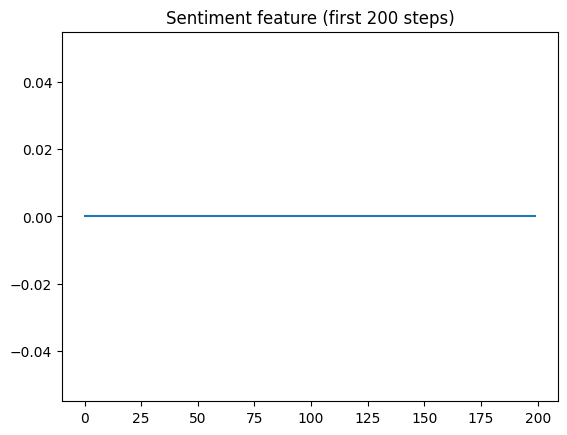

In [ ]:
import numpy as np

features = np.load("data/features.npy")
prices   = np.load("data/prices.npy")

print(features.shape)          # you saw (7450, 11)
print(features[:3])            # confirm no extra column added

print("features shape:", features.shape)
print("prices shape:", prices.shape)

print("features finite:", np.isfinite(features).all())
print("prices finite:", np.isfinite(prices).all())

state_dim = features.shape[1]
print("state_dim:", state_dim)

from core.config import load_config
cfg = load_config("config.yaml")

print("cfg.agent.state_dim:", cfg.agent.state_dim)

# Inspect last column distribution
sent_col = features[:, -1]

print("sentiment stats:")
print("  min:", sent_col.min())
print("  max:", sent_col.max())
print("  mean:", sent_col.mean())
print("  % zeros:", (sent_col == 0).mean())

import pandas as pd

df_check = pd.DataFrame(features[:200])
df_check.iloc[:, -1].plot(title="Sentiment feature (first 200 steps)")



